### importing require packages

In [133]:
from __future__ import print_function

import json
import os
import numpy as np
import sys
import h5py

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from keras.layers import Embedding
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.preprocessing import sequence
from intersect_embeddings import Embeddings
from keras.callbacks import ModelCheckpoint

import plotly.plotly as py
import plotly.graph_objs as go

from nltk.tokenize import word_tokenize
import random
from itertools import groupby

## Instantiate Embeddings 

In [7]:
embeddings = Embeddings(300, 4, 1, 4)

### Getting data from preprocessing

In [8]:
word2vec_model = embeddings.get_intersected_model()
word2index, index2word = embeddings.get_vocabulary()
word2vec_weights = word2vec_model.wv.syn0
tokenized_indexed_sentences = embeddings.get_indexed_sentences()

Loading Indexed Sentences...


In [9]:
word2index = {word:index+1 for word, index in word2index.items()}
index2word = {index:word for word, index in word2index.items()}

In [10]:
word2index

{'serves': 1978,
 'unpredictable': 22529,
 'papacy': 5100,
 'the_village': 41151,
 'murad_ii': 17698,
 'early-spring': 35732,
 '1868_to_1876': 44635,
 'anglo-saxon': 5438,
 'virginia_key': 52473,
 'idealogy': 39439,
 'dinophyte': 30121,
 'kick': 9552,
 'operation_tomahawk': 52247,
 'enablements': 24720,
 'rsa': 26941,
 'funneling': 35294,
 'week': 3138,
 'austrian': 2668,
 'matricide': 18887,
 'attraction': 3604,
 'treaties': 1176,
 'paul_sheehy': 30418,
 'occupy': 2352,
 'inn': 5584,
 "sant'agata": 38316,
 'windows_8': 3298,
 'oceania': 50836,
 '8_million': 22514,
 'contoller': 25765,
 'wallis_simpson': 20411,
 'consuls': 13563,
 'pandemic': 18087,
 'hanzhong': 45318,
 'conga': 26900,
 'education': 300,
 'enacting': 14167,
 'fireworks': 11270,
 'hayk': 51361,
 'the_princess_elizabeth': 29527,
 'lakulish': 45066,
 'inside': 1666,
 'the_dornbirner_ach': 17381,
 'indian_ocean': 45330,
 'the_gurjara_pratihara_empire': 19374,
 'vowel': 4211,
 'knell': 49814,
 'the_roman_kingdom': 14644,
 '

In [11]:
tokenized_indexed_sentences[0]

[1, 3, 2206, 9, 388, 498, 93, 108, 5, 0]

In [12]:
tokenized_indexed_sentences = [np.array(sentence) + 1 for sentence in tokenized_indexed_sentences if len(sentence) > 0]

In [13]:
tokenized_indexed_sentences[0]

array([   2,    4, 2207,   10,  389,  499,   94,  109,    6,    1])

In [14]:
new_weights = np.zeros((1, word2vec_weights.shape[1]))

In [15]:
new_weights = np.append(new_weights, word2vec_weights, axis=0)

In [16]:
new_weights.shape

(52731, 300)

In [17]:
new_weights[52730]

array([ 0.35742188,  0.03369141, -0.03881836,  0.07666016, -0.06079102,
        0.6328125 ,  0.05615234,  0.04345703,  0.00265503, -0.21582031,
        0.40234375, -0.0559082 , -0.15820312,  0.21289062,  0.28710938,
        0.54296875, -0.13085938,  0.14746094,  0.06738281, -0.171875  ,
        0.07373047, -0.0006485 , -0.10986328, -0.13476562,  0.06152344,
       -0.03833008, -0.07519531, -0.00221252,  0.09179688, -0.37890625,
       -0.31054688, -0.07666016, -0.484375  , -0.0546875 , -0.13183594,
       -0.33203125,  0.20996094,  0.25      ,  0.0534668 ,  0.08496094,
       -0.1875    ,  0.09960938,  0.24902344, -0.07714844, -0.01123047,
       -0.06787109,  0.21191406, -0.11865234, -0.01660156,  0.22265625,
       -0.37695312,  0.36914062, -0.51171875,  0.06640625, -0.19726562,
       -0.01818848,  0.0612793 , -0.21582031,  0.13574219, -0.08154297,
        0.18652344,  0.3203125 ,  0.26367188,  0.24609375,  0.01208496,
        0.04931641,  0.18652344,  0.29296875,  0.21289062,  0.06

### generating training data

In [18]:
window_size = 5
vocab_size = len(word2index)
print(vocab_size)

52730


In [19]:
maxlen = max([len(sentence) for sentence in tokenized_indexed_sentences])

In [20]:
tokenized_indexed_sentences = sequence.pad_sequences(tokenized_indexed_sentences)

In [24]:
len(tokenized_indexed_sentences[0])

42

In [25]:
seq_in = []
seq_out = []
# generating dataset
tokenized_indexed_sentences = [sentence for sentence in tokenized_indexed_sentences if len(sentence) > 0]
for sentence in tokenized_indexed_sentences:
    x = sentence
    y = np.append(sentence[1:], np.array(sentence[len(sentence)-1]))
    seq_in.append(x)
    seq_out.append([new_weights[index] for index in y])

# converting seq_in and seq_out into numpy array
seq_in = np.array(seq_in)
seq_out = np.array(seq_out)
n_samples = len(seq_in)
print ("Number of samples : ", n_samples)

Number of samples :  97974


## Defining model

In [26]:
# Changes to the model to be done here
model = Sequential()
model.add(Embedding(input_dim=new_weights.shape[0], output_dim=new_weights.shape[1], weights=[new_weights], mask_zero=True))
model.add(LSTM(1024, return_sequences=True))
model.add(LSTM(1024, return_sequences=True))
model.add(LSTM(300, return_sequences=True))
model.load_weights("../weights/lstm-3-1024-1024-batchsize-512-epochs-30-Sequence/weights.29.hdf5")
model.compile(loss='cosine_proximity', optimizer='adam',metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         15819300  
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 1024)        5427200   
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 1024)        8392704   
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 300)         1590000   
Total params: 31,229,204
Trainable params: 31,229,204
Non-trainable params: 0
_________________________________________________________________


In [27]:
model_weights_path = "../weights/lstm-3-1024-1024-batchsize-512-epochs-30-Sequence"
if not os.path.exists(model_weights_path):
    os.makedirs(model_weights_path)
checkpoint_path = model_weights_path + '/weights.{epoch:02d}.hdf5'
checkpoint = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_best_only=False, mode='max')

## Train Model

In [28]:
# model.fit(seq_in, seq_out, epochs=30, verbose=1, batch_size=512, callbacks=[checkpoint])

In [95]:
accuracy = model.evaluate(seq_in, seq_out, verbose=0)

### model predict

In [96]:
accuracy

[-0.00093102607380229658, 0.12032599566464017]

In [99]:
start = 0
sentence_test = "how is the "
indexed_sentences = embeddings.get_indexed_query(sentence_test)
print("indexed_sentences ",indexed_sentences)
sent = np.array(indexed_sentences) + 1
#pattern = list(seq_in[start])
pattern = list(sent)
print("\"",' '.join(index2word[index] for index in pattern))
for i in range(4):
    prediction = model.predict(np.array([pattern]))
    pred_word = word2vec_model.similar_by_vector(prediction[0][prediction.shape[1] - 1])[0][0]
    sys.stdout.write(pred_word+" ")
    pattern.append(word2index[pred_word])
    pattern = pattern[:len(pattern)]

indexed_sentences  [1, 11, 8, 2]
" squadstart how is the
consociational used for the 

In [ ]:


================================
# 1word
which nfl team represented the afc
what day the game


In [46]:
[[ 0.18412007  0.04542543  0.21795343 ...,  0.05103429  0.10333754
  -0.24055868]
 [ 0.06989234  0.02780185  0.18792398 ..., -0.0966404   0.1660459
   0.02869556]
 [-0.14092228 -0.10479636 -0.00315017 ..., -0.04664698 -0.0193012
  -0.18405525]
 ..., 
 [ 0.03898042  0.03138988  0.01595723 ..., -0.04284016  0.00147492 -0.        ]
 [-0.00096082 -0.00380996  0.01627631 ..., -0.01853406  0.01832031
  -0.00879718]
 [ 0.02848312  0.0082074   0.02930731 ..., -0.02281111 -0.00461099
  -0.00617669]]
chedi [[ 0.18412007  0.04542543  0.21795343 ...,  0.05103429  0.10333754
  -0.24055868]
 [ 0.06989234  0.02780185  0.18792398 ..., -0.0966404   0.1660459
   0.02869556]
 [-0.14092228 -0.10479636 -0.00315017 ..., -0.04664698 -0.0193012
  -0.18405525]
 ..., 
 [-0.00096082 -0.00380996  0.01627631 ..., -0.01853406  0.01832031
  -0.00879718]
 [ 0.02848312  0.0082074   0.02930731 ..., -0.02281111 -0.00461099
  -0.00617669]
 [ 0.00630879 -0.00051082  0.00335852 ..., -0.00979137  0.01898552 -0.        ]]
palace [[ 0.18412007  0.04542543  0.21795343 ...,  0.05103429  0.10333754
  -0.24055868]
 [ 0.06989234  0.02780185  0.18792398 ..., -0.0966404   0.1660459
   0.02869556]
 [-0.14092228 -0.10479636 -0.00315017 ..., -0.04664698 -0.0193012
  -0.18405525]
 ..., 
 [ 0.02848312  0.0082074   0.02930731 ..., -0.02281111 -0.00461099
  -0.00617669]
 [ 0.00630879 -0.00051082  0.00335852 ..., -0.00979137  0.01898552 -0.        ]
 [-0.01971216 -0.00750435  0.00110365 ..., -0.00632941 -0.00917979
  -0.03102284]]
as [[ 0.18412007  0.04542543  0.21795343 ...,  0.05103429  0.10333754
  -0.24055868]
 [ 0.06989234  0.02780185  0.18792398 ..., -0.0966404   0.1660459
   0.02869556]
 [-0.14092228 -0.10479636 -0.00315017 ..., -0.04664698 -0.0193012
  -0.18405525]
 ..., 
 [ 0.00630879 -0.00051082  0.00335852 ..., -0.00979137  0.01898552 -0.        ]
 [-0.01971216 -0.00750435  0.00110365 ..., -0.00632941 -0.00917979
  -0.03102284]
 [-0.00495647  0.00307422  0.00146239 ..., -0.00513899  0.01176982
  -0.0073432 ]]
polynesian [[ 0.18412007  0.04542543  0.21795343 ...,  0.05103429  0.10333754
  -0.24055868]
 [ 0.06989234  0.02780185  0.18792398 ..., -0.0966404   0.1660459
   0.02869556]
 [-0.14092228 -0.10479636 -0.00315017 ..., -0.04664698 -0.0193012
  -0.18405525]
 ..., 
 [-0.01971216 -0.00750435  0.00110365 ..., -0.00632941 -0.00917979
  -0.03102284]
 [-0.00495647  0.00307422  0.00146239 ..., -0.00513899  0.01176982
  -0.0073432 ]
 [ 0.06350882 -0.06063896  0.04302299 ..., -0.00506015 -0.33358458
  -0.0859012 ]]
interrupting [[ 0.18412007  0.04542543  0.21795343 ...,  0.05103429  0.10333754
  -0.24055868]
 [ 0.06989234  0.02780185  0.18792398 ..., -0.0966404   0.1660459
   0.02869556]
 [-0.14092228 -0.10479636 -0.00315017 ..., -0.04664698 -0.0193012
  -0.18405525]
 ..., 
 [-0.00495647  0.00307422  0.00146239 ..., -0.00513899  0.01176982
  -0.0073432 ]
 [ 0.06350882 -0.06063896  0.04302299 ..., -0.00506015 -0.33358458
  -0.0859012 ]
 [ 0.08807422 -0.09903663  0.09095348 ...,  0.09129792 -0.60016239
  -0.20244008]]
interrupting [[ 0.18412007  0.04542543  0.21795343 ...,  0.05103429  0.10333754
  -0.24055868]
 [ 0.06989234  0.02780185  0.18792398 ..., -0.0966404   0.1660459
   0.02869556]
 [-0.14092228 -0.10479636 -0.00315017 ..., -0.04664698 -0.0193012
  -0.18405525]
 ..., 
 [ 0.06350882 -0.06063896  0.04302299 ..., -0.00506015 -0.33358458
  -0.0859012 ]
 [ 0.08807422 -0.09903663  0.09095348 ...,  0.09129792 -0.60016239
  -0.20244008]
 [ 0.06299915 -0.07275582  0.10243553 ...,  0.13952872 -0.53645998
  -0.18396612]]
interrupting [[ 0.18412007  0.04542543  0.21795343 ...,  0.05103429  0.10333754
  -0.24055868]
 [ 0.06989234  0.02780185  0.18792398 ..., -0.0966404   0.1660459
   0.02869556]
 [-0.14092228 -0.10479636 -0.00315017 ..., -0.04664698 -0.0193012
  -0.18405525]
 ..., 
 [ 0.08807422 -0.09903663  0.09095348 ...,  0.09129792 -0.60016239
  -0.20244008]
 [ 0.06299915 -0.07275582  0.10243553 ...,  0.13952872 -0.53645998
  -0.18396612]
 [ 0.04037373 -0.05459753  0.09878035 ...,  0.14784373 -0.45596743
  -0.15770634]]
interrupting [[ 0.18412007  0.04542543  0.21795343 ...,  0.05103429  0.10333754
  -0.24055868]
 [ 0.06989234  0.02780185  0.18792398 ..., -0.0966404   0.1660459
   0.02869556]
 [-0.14092228 -0.10479636 -0.00315017 ..., -0.04664698 -0.0193012
  -0.18405525]
 ..., 
 [ 0.06299915 -0.07275582  0.10243553 ...,  0.13952872 -0.53645998
  -0.18396612]
 [ 0.04037373 -0.05459753  0.09878035 ...,  0.14784373 -0.45596743
  -0.15770634]
 [-0.0033474  -0.03021199  0.08110242 ...,  0.15047802 -0.30225605
  -0.0890971 ]]
nerves [[ 0.18412007  0.04542543  0.21795343 ...,  0.05103429  0.10333754
  -0.24055868]
 [ 0.06989234  0.02780185  0.18792398 ..., -0.0966404   0.1660459
   0.02869556]
 [-0.14092228 -0.10479636 -0.00315017 ..., -0.04664698 -0.0193012
  -0.18405525]
 ..., 
 [ 0.04037373 -0.05459753  0.09878035 ...,  0.14784373 -0.45596743
  -0.15770634]
 [-0.0033474  -0.03021199  0.08110242 ...,  0.15047802 -0.30225605
  -0.0890971 ]
 [-0.02403891 -0.00142898  0.04814288 ...,  0.11747674 -0.02676389
   0.0047134 ]]

SyntaxError: invalid syntax (<ipython-input-46-432fa0cc0048>, line 1)

In [ ]:
#e_model = embeddings.get_model()

In [ ]:
#e_model.similar_by_word("profitabl")

## Accuracy

In [ ]:
def accuracy():
    count = 0
    correct = 0
    for sub_sample_in, sub_sample_out in zip(seq_in, seq_out):
        ypred = model.predict_on_batch(np.expand_dims(sub_sample_in, axis=0))[0]
        ytrue = sub_sample_out
        pred_word = word2vec_model.similar_by_vector(ypred)[0][0]
        true_word = word2vec_model.similar_by_vector(ytrue)[0][0]
        similarity = word2vec_model.similarity(pred_word, true_word)
        if similarity == 1:
            correct += 1
        count += 1
    print("Accuracy {0}".format(correct/count))

In [ ]:
#seq_out[0]

In [ ]:
# accuracy()

In [ ]:
#model_results = model_fit_summary.history

In [ ]:
#model_results.update(model_fit_summary.params)

In [ ]:
#model_results["train_accuracy"] = accuracy()

In [ ]:
# n = no. of predictions
# accuracy = accuracy(400)
#print(model_results)

In [ ]:
#text_file_path = "../weights/lstm-2-1024-512-batchsize-128-epochs-25/model_results.json"

In [ ]:
#with open(text_file_path, "w") as f:
        #json.dump(model_results, f)
        

In [108]:
layer1_weights = model.layers[1].get_weights()[0]

In [118]:
layer1_weights.shape

(300, 4096)

In [115]:
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

In [134]:
trace = go.Heatmap(z=layer1_weights)
data=[trace]
py.iplot(data, filename='labelled-heatmap')

The draw time for this plot will be slow for all clients.


/home/nishant/venvs/autofill/lib/python3.5/site-packages/plotly/api/v1/clientresp.py:40: UserWarning:

Estimated Draw Time Too Long



In [ ]:
layer1_weights = model.layers[1].get_weights()[1]
trace = go.Heatmap(z=layer1_weights)
data=[trace]
py.iplot(data)

In [131]:
plt.figure(figsize=(1024, 10))

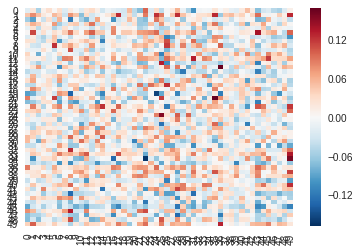

In [132]:
sns.heatmap(layer1_weights[:50, :50], )